In [4]:
import gurobipy

In [12]:
import matplotlib.pyplot as plt

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  9 00:01:55 2023

@author: Aditya Pavadad
"""

"""
Assignment 2
Group 28
Part d - implementation of part c
"""

# ---- Import libraries ----
import matplotlib.pyplot as plt
from gurobipy import *
import numpy as np
import csv


# ---- Parameters ----

"""Importing the dataset and extracting the appropriate data"""

filename = "cccc.txt"


with open(filename) as f:
    data = csv.reader(f, delimiter="\t")
    dataset = list(data)

for i in range(0,len(dataset)):
    for j in range(0,7):
        a = int(dataset[i][j])
        dataset[i][j] = a

node_id = []  # Stores the id's of the nodes
x_coord = []  # Stores the x coordinates of all the nodes
y_coord = []  # Stores the y coordinates of all the nodes
a = []  # Stores the demand for each node
RT = []  # Stores the ready time for each node (earliest time for delivery)
DT = []  # Stores the due time for each node (latest time for delivery)
ST = (
    []
)  # Stores the service time for each node (time needed for a delivery at each location )


for j in range(0, len(dataset)):
    node_id.append(dataset[j][0])
    x_coord.append(dataset[j][1])
    y_coord.append(dataset[j][2])
    a.append(dataset[j][3])
    RT.append(dataset[j][4])
    DT.append(dataset[j][5])
    ST.append(dataset[j][6])

"""Parameters"""

# Capacities for each vehicle, with the commented out sections being for each case

b = [130, 130,130]  # Case 1
# b = [60,60]  #Case 2
# b = [20,20,20,20,20,20] #Case 3

# Total number of vehicles
K = len(b)

"""Calculating the Euclidean distance between all nodes """

D = [[int for i in range(len(node_id))] for j in range(len(node_id))]


for i in range(len(node_id)):
    for j in range(len(node_id)):
        d = math.sqrt((x_coord[i] - x_coord[j]) ** 2 + (y_coord[i] - y_coord[j]) ** 2)
        D[i][j] = d

# Note for this programme, the assumption is made that 1 distance unit corresponds to 1 time unit
# This also allows us to use distance interchangably within constraints with time


# ---- Initialising Model ----

model = Model("Part c/d")


# ---- Sets and Indices ----

I = range(len(node_id))  # locations
J = range(len(node_id))  # locations
V = range(0, K)  # vehicles

# ---- Decision Variables ----

"""Initialising the dimensions for all the decision variables"""

x = [
    [[int for v in V] for j in J] for i in I
]  # Binary variable to indicate if a route between 2 nodes for a given vehicle is a solution (1 if route is taken, 0 otherwise)
z = [
    [int for v in V] for i in I
]  # Binary variable indicating if vehicle v visits node i
t = [
    [int for v in V] for i in I
]  # Total time taken for each vehicle up to a particular node
L = [[int for v in V] for i in I]  # Total load of each vehicle after each node
Y = [
    [int for v in V] for i in I 
] 
# Total number of depots
N = [int for i in range(3)]
"""Defining the type of decision variables"""
for i in I:
    for j in J:
        for v in V:
            x[i][j][v] = model.addVar(vtype=GRB.BINARY)

for i in I:
    for v in V:
        z[i][v] = model.addVar(vtype=GRB.BINARY)
        t[i][v] = model.addVar(lb=0, vtype=GRB.CONTINUOUS)
        L[i][v] = model.addVar(lb=0, vtype=GRB.CONTINUOUS)

for i in range(3):
    N[i] = model.addVar(lb = 0 , ub = 3, vtype = GRB.INTEGER)
    
    
# ---- Integerate the variables into the model ----
model.update()


# ---- Objective Function ----
model.setObjective(
    quicksum(x[i][j][v] * (D[i][j]) for i in I for j in J for v in V)
)  # Only a function of distance as that is the parameter to minimize

model.modelSense = GRB.MINIMIZE
model.update()

# ---- Constraints ----
"""Initialising all constraints"""

con1 = {}
con2 = {}
con3 = {}
con4 = {}
con5 = {}
con6 = {}
con7 = {}
con8 = {}
con9 = {}
con10 = {}
con11 = {}

M = 10000

# Ensures that every node is visited by only one vehicle
for i in range(3, len(node_id)):
    con1 = model.addConstr(quicksum(z[i][v] for v in V) == 1)

# # Ensures that multiple vehicles can start from the Depot
for i in range(0,3):
    con2 = model.addConstr(quicksum(z[i][v] for v in V) == N[i] )
    
con20 = model.addConstr(quicksum(N[i] for i in range(3)) == K)    

# Ensures that the sum of demand of a tour of each vehicle needs to be less than overall capacity of the vehicle
for v in V:
    con3 = model.addConstr(quicksum(a[i] * z[i][v] for i in I) <= b[v])

# Ensures that each nodes is visited by particular vehicle v once
for v in V:
    for i in I:
        con4 = model.addConstr(quicksum(x[i][j][v] for j in J) == z[i][v])

# Ensures that each nodes is left by particular vehicle v once
for v in V:
    for j in J:
        con5 = model.addConstr(quicksum(x[i][j][v] for i in I) == z[j][v])

# Defining the total time taken up to a certain node for a certain vehicle
for v in V:
    for j in range(3, len(node_id)):
        con6 = model.addConstr(
            t[j][v] >= quicksum((ST[i] + D[i][j] + t[i][v]) * x[i][j][v] for i in I)
        )

# Ensures that there is no subtouring
for i in I:
    for j in range(3, len(node_id)):
        for v in V:
            con7 = model.addConstr(t[i][v] + D[i][j] - M * (1 - x[i][j][v]) <= t[j][v])

# Ensures that the arrival of the vehicle is within the ready-time and due-time
for v in V:
    for i in I:
        con8 = model.addConstr(RT[i] * quicksum(x[i][j][v]  for j in J) <= t[i][v])
        con9 = model.addConstr(t[i][v] <= DT[i])

# Defines the changing load of each vehicle after each node
for v in V:
    for j in range(3, len(node_id)):
        con10 = model.addConstr(
            L[j][v] == quicksum((L[i][v] - a[j]) * x[i][j][v] for i in I)
        )


# ---- Gurobi Parameters ----
"""Ensuring that the optimal solution is found and not a heuristic"""

model.update()

# model.setParam("OutputFlag", False)  # silencing gurobi output or not
# model.setParam ('Heuristic', 0.5)
model.setParam('Heuristics', 0.5)

# find the optimal solution
model.write("output.lp")  # print the model in .lp format file

model.optimize()




Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-14
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1544 rows, 1653 columns and 8199 nonzeros
Model fingerprint: 0x568e0fc1
Model has 114 quadratic constraints
Variable types: 132 continuous, 1521 integer (1518 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 2e+02]
  Objective range  [2e+00, 8e+01]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 306 rows and 225 columns
Presolve time: 0.12s
Presolved: 4448 rows, 5556 columns, 24423 nonzeros
Presolved model has 2064 SOS constraint(s)
Variable types: 3048 continuous, 2508 integer (2328 binary)
Found heuristic sol

In [92]:
filename = "cccc.txt"

with open(filename, "r") as file:
    file_content = file.read()
`


data = []
for line in file_content.split('\n'):
    data.append(line.split())

dat = np.array(data, dtype = 'int')

route

x_coords = []
y_coords = []
for path in route:
    x_coords.append(dat[path, 1])
    y_coords.append(dat[path, 2])

x_coords

y_coords

plt.plot(x_coords[0], y_coords[0], 'ro-', lw = 1);
plt.plot(x_coords[0][0], y_coords[0][0], 'ko');


plt.plot(x_coords[1], y_coords[1], 'go-', lw = 1);
plt.plot(x_coords[2], y_coords[2], 'bo-', lw = 1);
plt.plot(x_coords[1][0], y_coords[1][0], 'ko');
plt.plot(x_coords[2][0], y_coords[2][0], 'ko');

0	40	50	0	0	1236	0
1	22	40	0	0	1236	0
2	25	70	0	0	1236	0
3	40	69	20	482	842	90
4	40	66	20	18	378	90
5	38	68	20	110	470	90
6	38	70	10	390	750	90
7	25	85	20	507	867	90
8	22	75	30	30	390	90
9	22	85	10	414	774	90
10	25	50	10	15	375	90
11	25	52	40	17	377	90
12	25	55	10	482	842	90
13	23	52	10	109	469	90
14	23	55	20	390	750	90
15	26	32	10	668	1028	90
16	25	30	10	576	936	90
17	25	35	10	761	1121	90
18	40	5	30	231	591	90
19	40	15	40	35	395	90
20	38	5	30	323	683	90
21	38	15	10	516	876	90


In [120]:
data = []
for line in file_content.split('\n'):
    data.append(line.split())

In [126]:
dat = np.array(data, dtype = 'int')

In [94]:
route

[[2, 8, 5, 4, 3, 6, 9, 7, 2],
 [1, 10, 11, 13, 14, 12, 17, 1],
 [1, 19, 18, 20, 21, 16, 15, 1]]

In [140]:
x_coords = []
y_coords = []
for path in route:
    x_coords.append(dat[path, 1])
    y_coords.append(dat[path, 2])

In [143]:
x_coords

[array([25, 22, 38, 40, 40, 38, 22, 25, 25]),
 array([22, 25, 25, 23, 23, 25, 25, 22]),
 array([22, 40, 40, 38, 38, 25, 26, 22])]

In [144]:
y_coords

[array([70, 75, 68, 66, 69, 70, 85, 85, 70]),
 array([40, 50, 52, 52, 55, 55, 35, 40]),
 array([40, 15,  5,  5, 15, 30, 32, 40])]

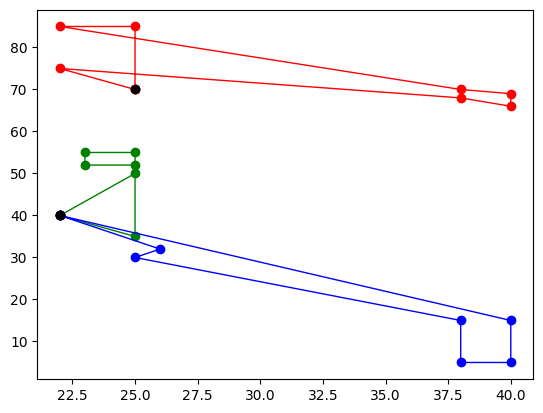

In [150]:
plt.plot(x_coords[0], y_coords[0], 'ro-', lw = 1);
plt.plot(x_coords[0][0], y_coords[0][0], 'ko');


plt.plot(x_coords[1], y_coords[1], 'go-', lw = 1);
plt.plot(x_coords[2], y_coords[2], 'bo-', lw = 1);
plt.plot(x_coords[1][0], y_coords[1][0], 'ko');
plt.plot(x_coords[2][0], y_coords[2][0], 'ko');

In [2]:
if model.status == GRB.Status.OPTIMAL:
    print('\n' + 'Solution to part E/F: ')`a

    print('\n' + 'Case Parameters: ')
    print('\n' + 'Number of vehicles: ' + str(K))
    print('\n' + 'Capacity of each vehicle: ' + str(b[0]))


    #Total Distance Travelled
    print ('\n Total distance for all vehicles for all deliveries: %10.2f Units of Distance' % model.objVal)

    #Sequence of locations visited by each vehicle
    fig, ax = plt.subplots()
    route = []
    for v in V:
        print ('\n Tour of vehicle no. ' + str(v+1) + ' is: ')
        k = 0
        orderofvisit = [0]
        lenz = 0
        for i in I:
            value = z[i][v].x
            lenz = lenz + value
        while k < lenz:
            i = orderofvisit[k]
            for j in I:
                if x[i][j][v].x == 1:
                    orderofvisit.append(j)
                    k = k + 1
        print('\t' + str(orderofvisit))
        route.append(orderofvisit)
        #Time of visit at each location by each vehicle:
        total_time_v = 0
        print ('\n Time of visit at each node by vehicle no. ' + str(v+1) + ' is: ')
        for i in range(len(orderofvisit)-1):
            time = '%0.2f' % t[int(orderofvisit[i])][v].x
            print('\t' + str(time))

        #Load of each vehicle at each location:
        print ('\n Load of vehicle no. ' + str(v+1) + ' at each location in the route:')
        for i in range(len(orderofvisit)-1):
            load = '%0.2f' % L[int(orderofvisit[i])][v].x
            print('\t' + str(load))


         #2D plot of the solution
        x_pos_order = []
        y_pos_order = []
        col = (np.random.random(), np.random.random(), np.random.random())
        #colors ['']
        for i in range(len(orderofvisit)):

            j = int(orderofvisit[i])
            x_pos_order.append(x_coord[j])
            y_pos_order.append(y_coord[j])


            ax.plot(x_pos_order, y_pos_order, '.-', lw = 1, color = col)
            plt.xlabel("X Coordinate Position")
            plt.ylabel("Y Coordinate Position")
            plt.title("2D Plot of the Solution")


            txt = j
            ax.annotate(txt, (x_pos_order[i], y_pos_order[i]),fontsize = 10)
            ax.annotate('',
                                xytext=(x_pos_order[i-1], y_pos_order[i-1]),
                                xy=(x_pos_order[i], y_pos_order[i]),
                                size=5)

#             txt = j
#             ax.annotate(txt, (x_pos_order[i], y_pos_order[i]),fontsize = 15)
#             ax.annotate('',
#                                  xytext=(x_pos_order[i-1], y_pos_order[i-1]),
#                                  xy=(x_pos_order[i], y_pos_order[i]),
#                                  arrowprops=dict(arrowstyle="->", color= col),
#                                  size=10)
else:
    print ('\nNo feasible solution found')

SyntaxError: invalid syntax (1605893781.py, line 2)

In [3]:
import pandas as pd

def conv(y):
    return y.x

In [4]:
df0 = pd.DataFrame(np.array(x)[:,:,0]).applymap(conv)
df1 = pd.DataFrame(np.array(x)[:,:,1]).applymap(conv)
df2 = pd.DataFrame(np.array(x)[:,:,2]).applymap(conv)

C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_30456\756365652.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df0 = pd.DataFrame(np.array(x)[:,:,0]).applymap(conv)
C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_30456\756365652.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df1 = pd.DataFrame(np.array(x)[:,:,1]).applymap(conv)
C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_30456\756365652.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = pd.DataFrame(np.array(x)[:,:,2]).applymap(conv)


In [5]:
route = [[], [], []]

route[0].append(df0[:3].sum(axis=1)[df0[:3].sum(axis=1) > 0].index[0])
route[1].append(df1[:3].sum(axis=1)[df1[:3].sum(axis=1) > 0].index[0])
route[2].append(df2[:3].sum(axis=1)[df2[:3].sum(axis=1) > 0].index[0])

i = 0
while True:
    route[0].append(df0.iloc[route[0][i]][df0.iloc[route[0][i]] > 0].index[0])
    i += 1
    if route[0][i] == route[0][0]:
        break
        
i = 0
while True:
    route[1].append(df1.iloc[route[1][i]][df1.iloc[route[1][i]] > 0].index[0])
    i += 1
    if route[1][i] == route[1][0]:
        break
        
i = 0
while True:
    route[2].append(df2.iloc[route[2][i]][df2.iloc[route[2][i]] > 0].index[0])
    i += 1
    if route[2][i] == route[2][0]:
        break

In [6]:
df0.iloc[route[0][0]][df0.iloc[route[0][0]] > 0].index[0]

8

In [7]:
route

[[2, 8, 5, 4, 3, 6, 9, 7, 2],
 [1, 10, 11, 13, 14, 12, 17, 1],
 [1, 19, 18, 20, 21, 16, 15, 1]]

In [11]:
orderofvisit

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [70]:
route[0].append(df0[:3].sum(axis=1)[df0[:3].sum(axis=1) > 0].index[0])
route[1].append(df1[:3].sum(axis=1)[df1[:3].sum(axis=1) > 0].index[0])
route[2].append(df2[:3].sum(axis=1)[df2[:3].sum(axis=1) > 0].index[0])

In [79]:
i = 0
while True:
    route[0].append(df0.iloc[route[0][i]][df0.iloc[route[0][i]] > 0].index[0])
    i += 1
    if route[0][i] == route[0][0]:
        break

In [29]:
z

[[<gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>],
 [<gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>],
 [<gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>],
 [<gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>],
 [<gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>],
 [<gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>],
 [<gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>],
 [<gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>,
  <gurobi.Var *Awaiting Model Update*>],
 [<gurobi.Var *Awaiting Model Up

In [68]:
df2[:3].sum(axis=1) > 0

0    False
1     True
2    False
dtype: bool